In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# LSTM

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)


model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    #attention_module=attention_module,
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, Y_val)



Training:  52%|█████▏    | 52/100 [00:02<00:02, 20.05epoch/s]

Epoch 50: Train Loss = 0.0085


Training: 100%|██████████| 100/100 [00:04<00:00, 20.14epoch/s]

Epoch 100: Train Loss = 0.0083

Validation Forecast Error Metrics:
  MSE   = 0.011541
  RMSE  = 0.107430
  MAE   = 0.085829


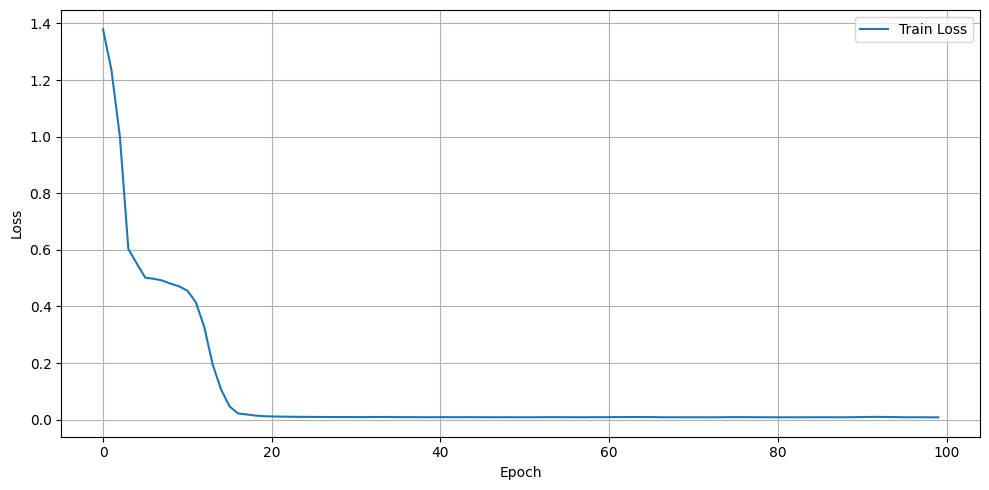

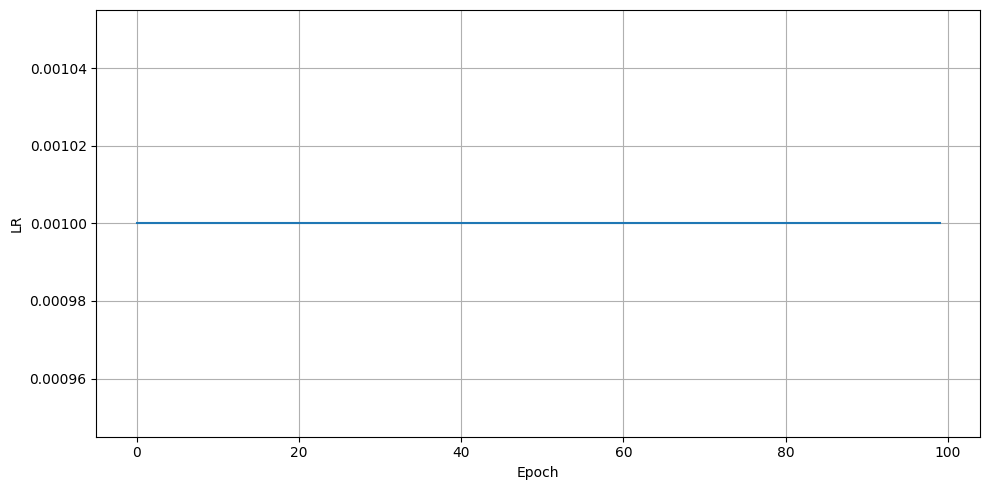

In [3]:
trainer.plot_learning_curves()

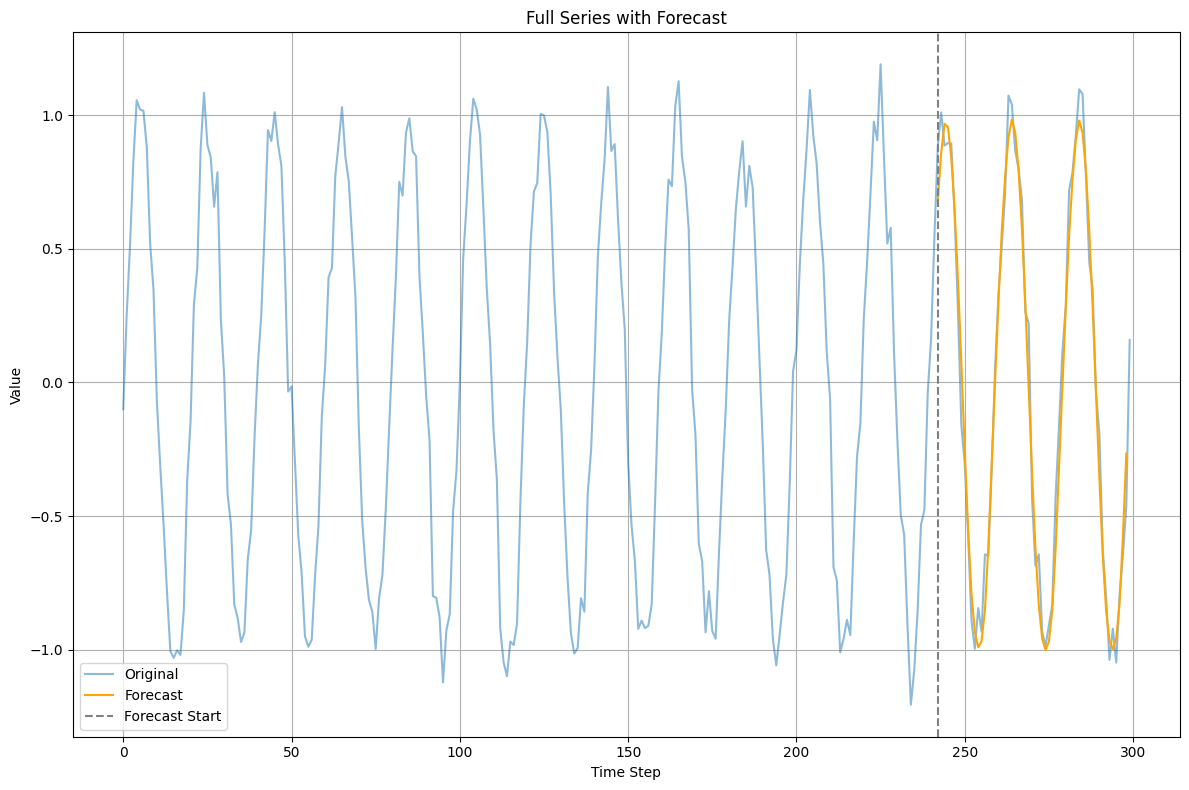

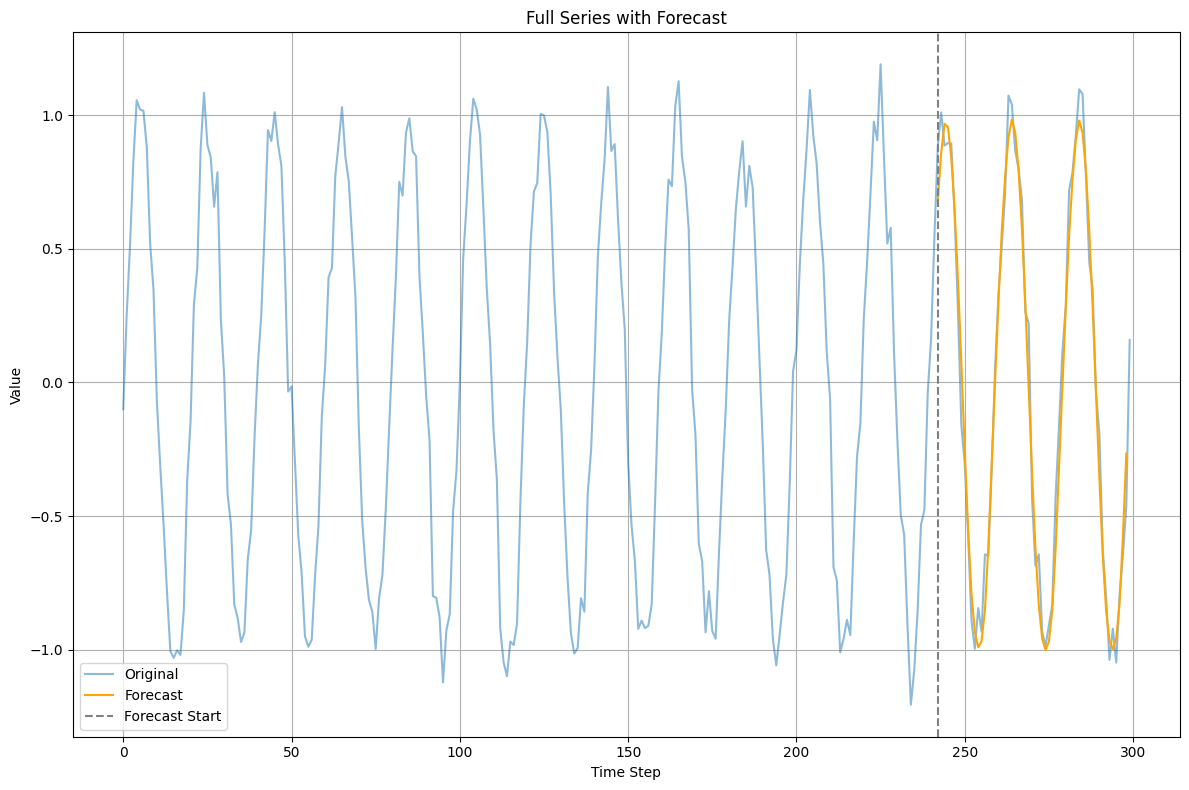

In [4]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)


# Transformer

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 2),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

attention_module = AttentionLayer(
    method=model_params.get("attention_method", "dot"),
    attention_backend=model_params.get(
        "attention_backend", "xformers"
    ),
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="transformer",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())
#trainer.set_config('num_epochs', 200)
# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)




Training:  50%|█████     | 50/100 [00:13<00:12,  3.88epoch/s]

Epoch 50: Train Loss = 0.0085


Training: 100%|██████████| 100/100 [00:28<00:00,  3.54epoch/s]

Epoch 100: Train Loss = 0.0079


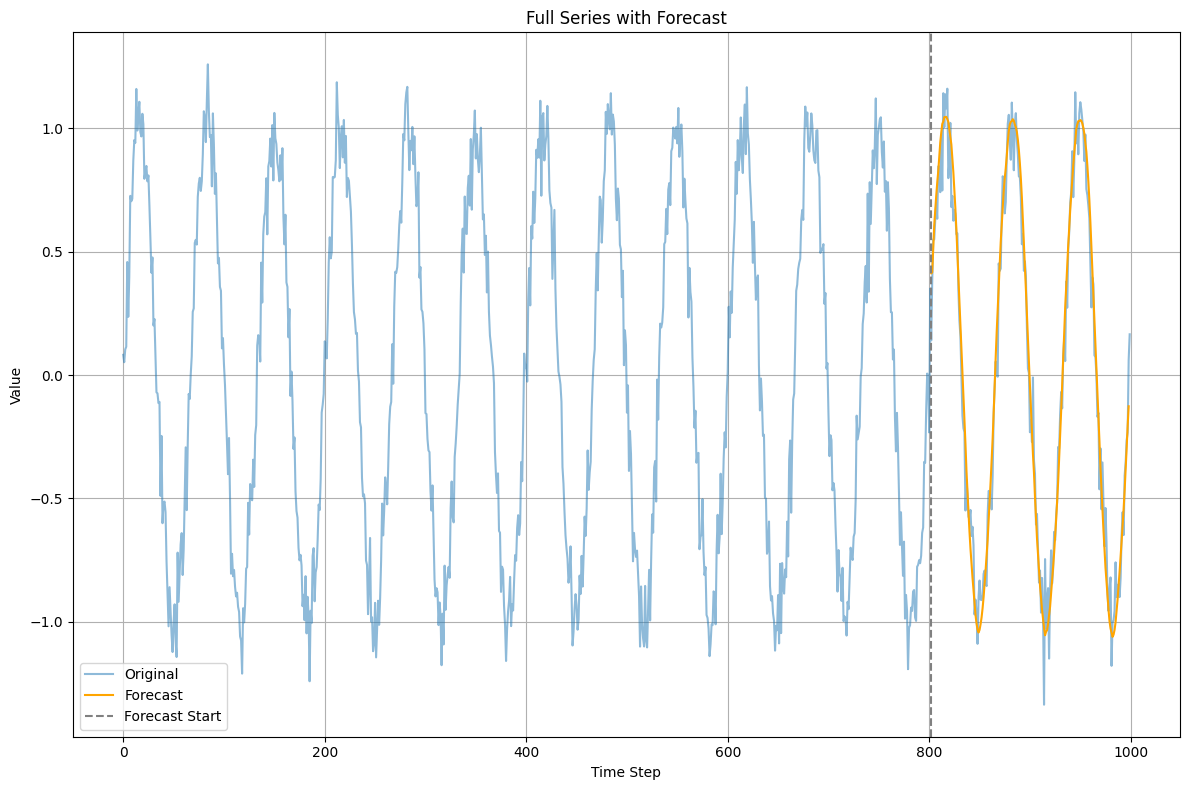

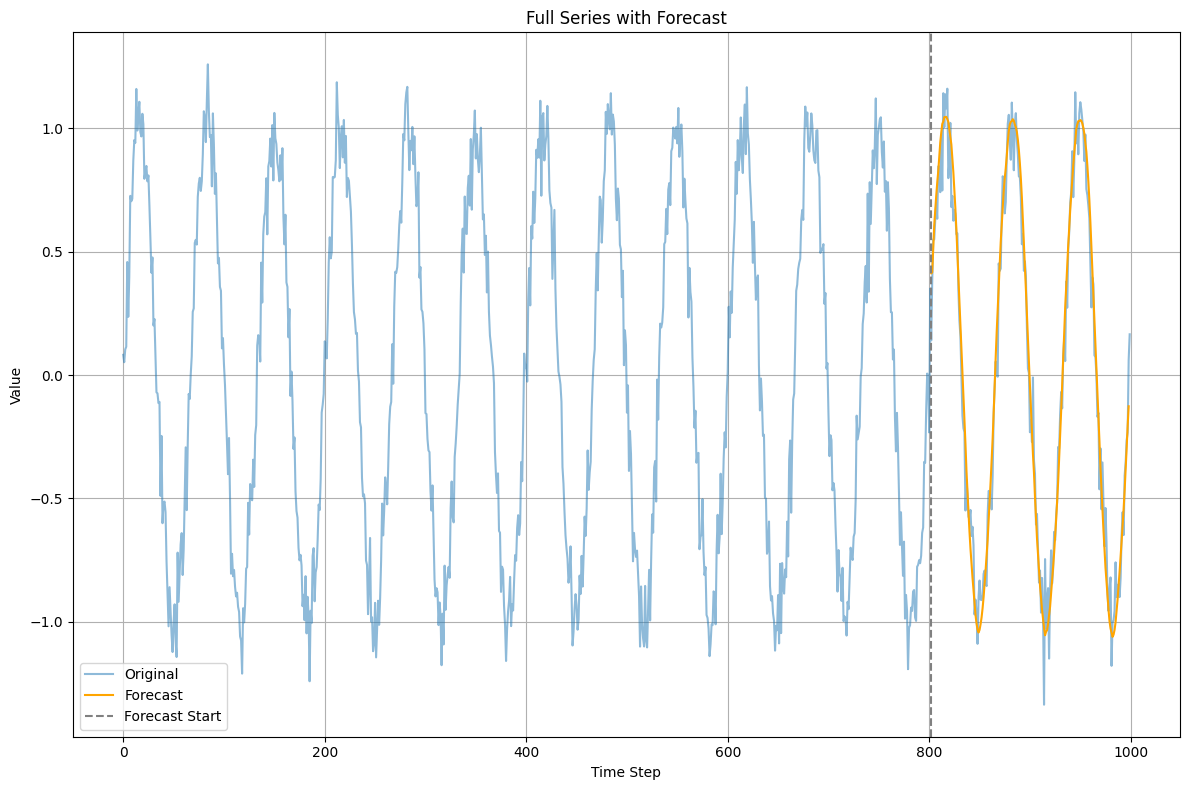

In [6]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)